In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras import (
    datasets,
    layers, 
    losses, 
    models,
    callbacks,
    optimizers,
    metrics,
)
from keras import backend as K
from scipy.stats import norm

2024-03-12 19:18:00.684342: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-12 19:18:01.510113: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
IMAGE_SIZE = 32
BATCH_SIZE = 100
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 2
EPOCHS = 5
BETA = 500

In [3]:
(x_train,y_train),(x_test, y_test) = datasets.fashion_mnist.load_data()

In [4]:
# Originally image is 28x28
# pad image to 32x32

def preprocess(imgs):
    imgs = imgs.astype("float32") / 255.0
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs

In [5]:
x_train = preprocess(x_train)
x_test = preprocess(x_test)

In [6]:
x_train.shape

(60000, 32, 32, 1)

In [7]:
x_test.shape

(10000, 32, 32, 1)

<Figure size 640x480 with 0 Axes>

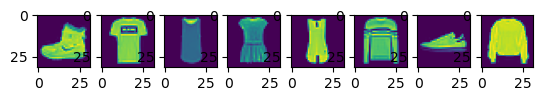

In [8]:
plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1,8) 

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
for i in range(0,8):
    axarr[i].imshow(x_train[i])


# Build a VAE

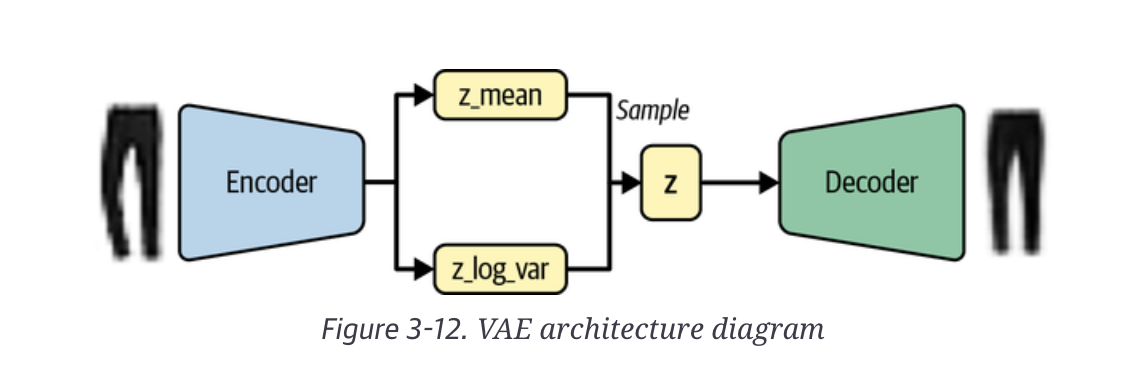

In [9]:
# to compute z value from z_mean and z_log_var which are the inputs
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


In [10]:
encoder_input = layers.Input(
    shape=(32, 32, 1), name="encoder_input"
)
# input (?, 32, 32, 1)
x = layers.Conv2D(32, (3, 3), strides=2, activation="relu", padding="same")(
    encoder_input
)
# output (?,16,16,32)
# parameters - (3x3x1 + 1) * 32 = 320

# input (?,16,16,32)
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)
# output (?,8,8,64)
# parameters - (3x3x32 + 1)*64 = 18496

# input (?,8,8,64)
x = layers.Conv2D(128, (3, 3), strides=2, activation="relu", padding="same")(x)
# ouput (?,4,4,128)
# parameters - (3x3x64 + 1)*128 = 73856

shape_before_flattening = K.int_shape(x)[1:]

# input (?,4,4,128)
x = layers.Flatten()(x)
# output (?,2048)
# parameters = 0

z_mean = layers.Dense(2, name="z_mean")(x) 
# output - mean of two dimensions for 2D latent representation
# parameters = 4098

z_log_var = layers.Dense(2, name="z_log_var")(x)
# output - log variance of two dimensions for 2D latent representation
# parameters = 4098

z = Sampling()([z_mean, z_log_var])
# create a reconstruction z using the mean and the log var
# parameters = 0

encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder") 
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 32, 32, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 16, 16, 32)           320       ['encoder_input[0][0]']       
                                                                                                  
 conv2d_1 (Conv2D)           (None, 8, 8, 64)             18496     ['conv2d[0][0]']              
                                                                                                  
 conv2d_2 (Conv2D)           (None, 4, 4, 128)            73856     ['conv2d_1[0][0]']            
                                                                                            

2024-03-12 19:24:54.479826: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [11]:
shape_before_flattening

(4, 4, 128)

In [12]:
# Decoder EMBEDDING_DIM = 2
decoder_input = layers.Input(shape=(EMBEDDING_DIM,), name="decoder_input")

# input - (?, 2)
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
# output - (?,2048)
# parameters - (2+1)*2048 = 6144

# input - (?,2048)
x = layers.Reshape(shape_before_flattening)(x)
# output - (?, 4,4,128)
# parameters - 0

# input - (?, 4,4,128)
x = layers.Conv2DTranspose(
    128, (3, 3), strides=2, activation="relu", padding="same"
)(x)
# output - (?,8,8,128)
# parameters - (3x3x128+1)*128 = 147584

# input - (?,8,8,128)
x = layers.Conv2DTranspose(
    64, (3, 3), strides=2, activation="relu", padding="same"
)(x)
# output - (?,16,16,64)
# parameters - (3x3x128+1)*64 = 73792

# input - (?,16,16,64)
x = layers.Conv2DTranspose(
    32, (3, 3), strides=2, activation="relu", padding="same"
)(x)
# output - (?,32,32,32)
# parameters - (3x3x64 + 1)*32 = 18464

# input - (?,32,32,32)
decoder_output = layers.Conv2D(
    1,
    (3, 3),
    strides=1,
    activation="sigmoid",
    padding="same",
    name="decoder_output",
)(x)
# output - (?,32,32,1) with strides = 1
# parameters - (3x3x32+1)*1 = 289

decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 2048)              6144      
                                                                 
 reshape (Reshape)           (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 8, 8, 128)         147584    
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 16, 16, 64)        73792     
 Transpose)                                                      
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 32, 32, 32)        18464 

In [13]:
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        """Call the model on a particular input."""
        z_mean, z_log_var, z = encoder(inputs)
        reconstruction = decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        """Step run during training."""
        # TensorFlow’s Gradient Tape is a mechanism that allows the computation of gradients of operations 
        # executed during a forward pass of a model. To use it, you need to wrap the code that performs the 
        # operations you want to differentiate in a tf.GradientTape() context. Once you have recorded the 
        # operations, you can compute the gradient of the loss function with respect to some variables by 
        # calling tape.gradient(). The gradients can then be used to update the variables with the optimizer.
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data)
            reconstruction_loss = tf.reduce_mean(
                BETA
                * losses.binary_crossentropy(
                    data, reconstruction, axis=(1, 2, 3)
                )
            )
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5
                    * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis=1,
                )
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        """Step run during validation."""
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(
            BETA
            * losses.binary_crossentropy(data, reconstruction, axis=(1, 2, 3))
        )
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                axis=1,
            )
        )
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [14]:
# Create a variational autoencoder
vae = VAE(encoder, decoder)

# Train the variational autoencoder

In [15]:
# Compile the variational autoencoder
optimizer = optimizers.Adam(learning_rate=0.0005)
vae.compile(optimizer=optimizer)

In [16]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint",
    save_weights_only=False,
    save_freq="epoch",
    monitor="loss",
    mode="min",
    save_best_only=True,
    verbose=0,
)
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

In [17]:
vae.fit(
    x_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=(x_test, x_test),
    callbacks=[model_checkpoint_callback, tensorboard_callback],
)

Epoch 1/5
600/600 [==============================] - 44s 70ms/step - total_loss: 162.3330 - reconstruction_loss: 157.9263 - kl_loss: 4.4066 - val_loss: 142.2315 - val_reconstruction_loss: 137.4221 - val_kl_loss: 4.8095
Epoch 2/5
600/600 [==============================] - 42s 70ms/step - total_loss: 136.0561 - reconstruction_loss: 131.1846 - kl_loss: 4.8716 - val_loss: 138.2383 - val_reconstruction_loss: 133.2868 - val_kl_loss: 4.9515
Epoch 3/5
600/600 [==============================] - 43s 71ms/step - total_loss: 134.2666 - reconstruction_loss: 129.2740 - kl_loss: 4.9926 - val_loss: 136.5871 - val_reconstruction_loss: 131.3789 - val_kl_loss: 5.2082
Epoch 4/5
600/600 [==============================] - 42s 70ms/step - total_loss: 133.4012 - reconstruction_loss: 128.3279 - kl_loss: 5.0733 - val_loss: 136.1940 - val_reconstruction_loss: 130.9506 - val_kl_loss: 5.2434
Epoch 5/5
600/600 [==============================] - 42s 70ms/step - total_loss: 132.8291 - reconstruction_loss: 127.7056 - 

In [18]:
# Save the final models
vae.save("./models/vae")
encoder.save("./models/encoder")
decoder.save("./models/decoder")

INFO:tensorflow:Assets written to: ./models/vae/assets


INFO:tensorflow:Assets written to: ./models/vae/assets


INFO:tensorflow:Assets written to: ./models/encoder/assets


INFO:tensorflow:Assets written to: ./models/encoder/assets


INFO:tensorflow:Assets written to: ./models/decoder/assets


INFO:tensorflow:Assets written to: ./models/decoder/assets


# Reconstruct using the variational autoencoder

In [19]:
# Select a subset of the test set
n_to_predict = 5000
example_images = x_test[:n_to_predict]
example_labels = y_test[:n_to_predict]

In [20]:
# Create autoencoder predictions and display
z_mean, z_log_var, reconstructions = vae.predict(example_images)
print("Example real clothing items")
display(example_images)
print("Reconstructions")
display(reconstructions)

157/157 [==============================] - 1s 8ms/step
Example real clothing items


array([[[[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        ...,

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]]],


       [[[0.        ],
         [0.        ],
         [0.  

Reconstructions


array([[[[9.29908219e-06],
         [7.70936708e-07],
         [5.06990148e-07],
         ...,
         [1.30859235e-05],
         [1.71042811e-05],
         [3.96379648e-04]],

        [[2.36047725e-07],
         [4.13041601e-09],
         [1.86958591e-08],
         ...,
         [5.92542108e-07],
         [3.24160084e-07],
         [1.51851027e-05]],

        [[9.69784395e-08],
         [9.45683443e-09],
         [2.11307480e-07],
         ...,
         [6.34545904e-06],
         [1.13436226e-06],
         [2.11688111e-05]],

        ...,

        [[6.02845830e-07],
         [3.77539777e-09],
         [1.94751970e-09],
         ...,
         [5.20409493e-09],
         [3.19705684e-09],
         [3.10359070e-07]],

        [[1.54096745e-06],
         [1.82398292e-08],
         [6.49057430e-09],
         ...,
         [1.94221226e-08],
         [2.76775114e-09],
         [3.74093588e-07]],

        [[1.37229625e-04],
         [2.79358983e-06],
         [1.70865349e-06],
         ...,
 

# Embed using the encoder

In [21]:
# Encode the example images
z_mean, z_var, z = encoder.predict(example_images)

157/157 [==============================] - 0s 2ms/step


In [22]:
# Some examples of the embeddings
print(z[:10])

[[-0.45741758 -1.2073789 ]
 [-0.6649132   0.7060125 ]
 [ 1.9136537   1.5658637 ]
 [ 2.1322129   0.43555593]
 [-0.17612559  0.0290031 ]
 [ 1.2217004   1.0693848 ]
 [ 0.9269078  -0.30315548]
 [ 0.19118784 -0.04118881]
 [ 1.8488349  -2.8321598 ]
 [-0.6280434  -2.490942  ]]


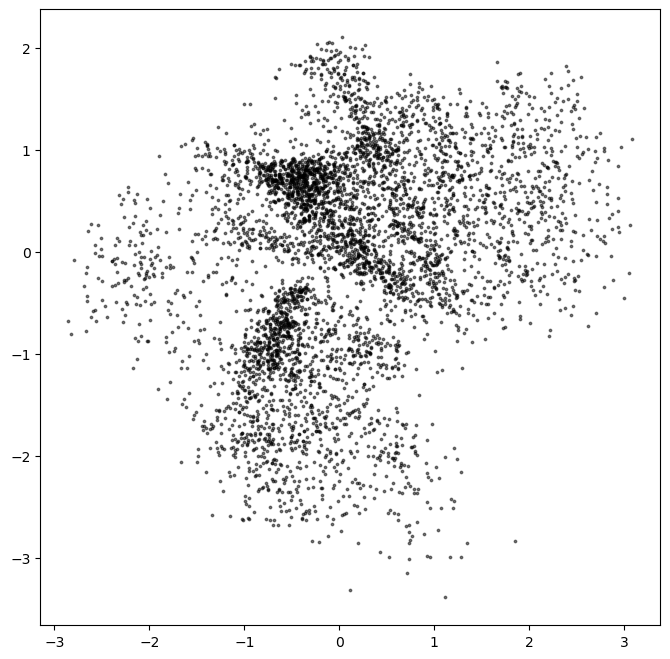

In [23]:
# Show the encoded points in 2D space
figsize = 8

plt.figure(figsize=(figsize, figsize))
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=3)
plt.show()

# Generate using the decoder

In [24]:
# Sample some points in the latent space, from the standard normal distribution
grid_width, grid_height = (6, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, 2))

In [25]:
z_sample

array([[-0.60562431, -1.32338192],
       [ 1.85624543, -0.54125035],
       [ 0.09771801, -1.34521637],
       [-0.05857492, -1.82310193],
       [ 1.08975023,  0.04184465],
       [-0.0849342 , -0.76052879],
       [-0.11135502,  0.96660886],
       [-0.31615167,  1.0787605 ],
       [-1.6068107 , -0.1285384 ],
       [ 0.32751651,  0.23300537],
       [-1.46782619, -1.14230556],
       [ 0.97163527, -0.32435038],
       [ 0.08361606, -1.30466219],
       [-0.58744531,  1.11669099],
       [ 1.15005448, -0.67023572],
       [-0.35509539, -0.3813008 ],
       [-0.37808722,  1.43518787],
       [ 0.19685735,  0.61884887]])

In [26]:
# Decode the sampled points
reconstructions = decoder.predict(z_sample)


1/1 [==============================] - 0s 93ms/step


In [27]:
# Convert original embeddings and sampled embeddings to p-values
p = norm.cdf(z)
p_sample = norm.cdf(z_sample)

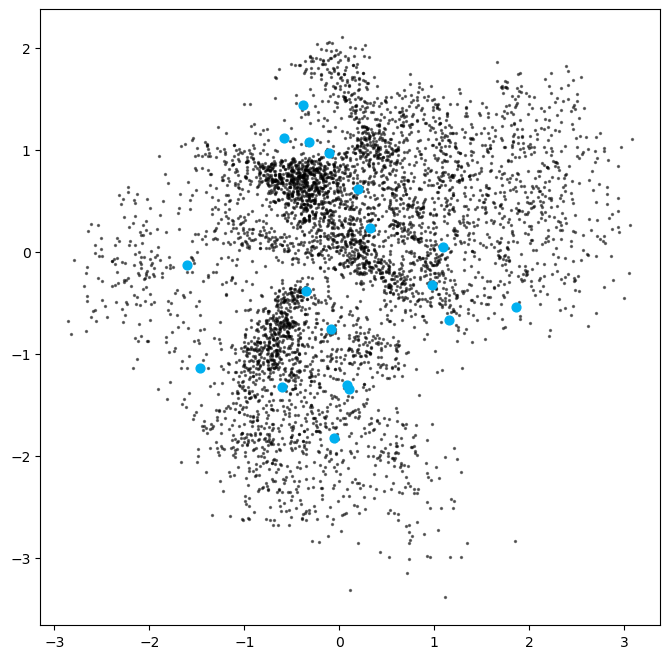

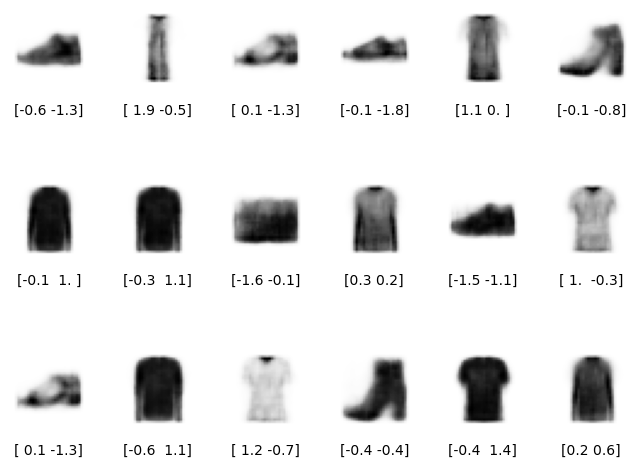

In [28]:
# Draw a plot of...
figsize = 8
plt.figure(figsize=(figsize, figsize))

# ... the original embeddings ...
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=2)

# ... and the newly generated points in the latent space
plt.scatter(z_sample[:, 0], z_sample[:, 1], c="#00B0F0", alpha=1, s=40)
plt.show()

# Add underneath a grid of the decoded images
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(z_sample[i, :], 1)),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

# Explore the latent space

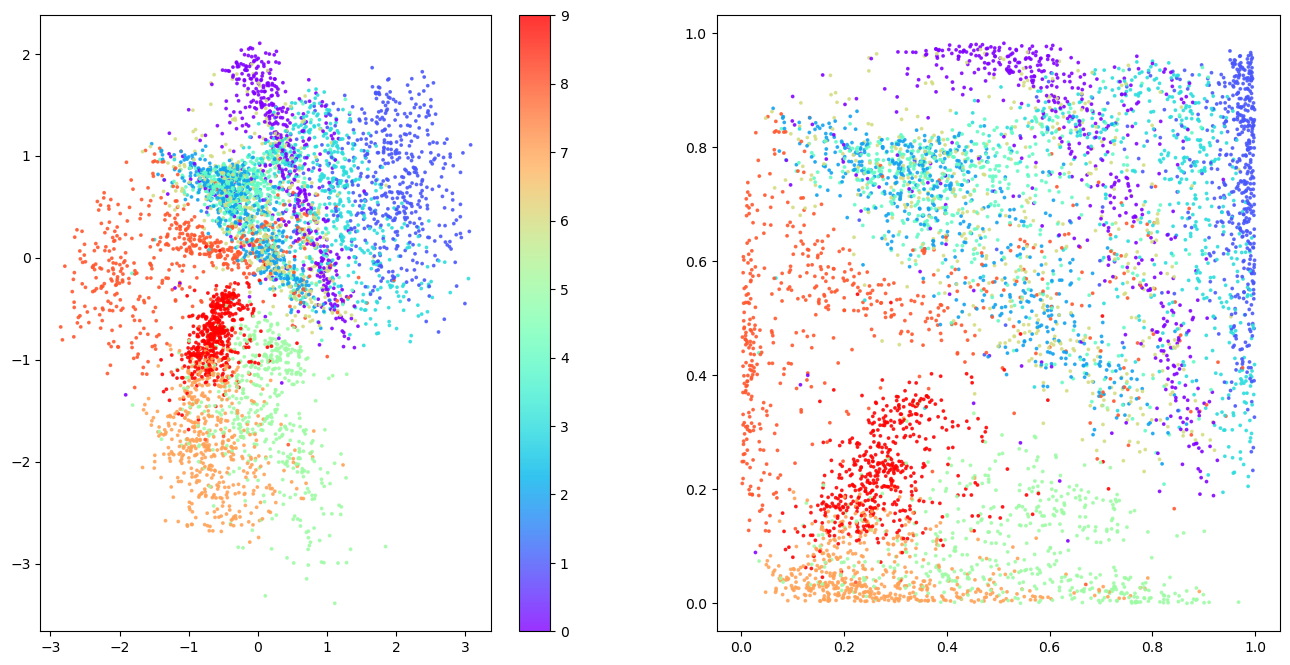

In [29]:
# Colour the embeddings by their label (clothing type - see table)
figsize = 8
fig = plt.figure(figsize=(figsize * 2, figsize))
ax = fig.add_subplot(1, 2, 1)
plot_1 = ax.scatter(
    z[:, 0], z[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=3
)
plt.colorbar(plot_1)
ax = fig.add_subplot(1, 2, 2)
plot_2 = ax.scatter(
    p[:, 0], p[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=3
)
plt.show()

8/8 [==============================] - 0s 7ms/step


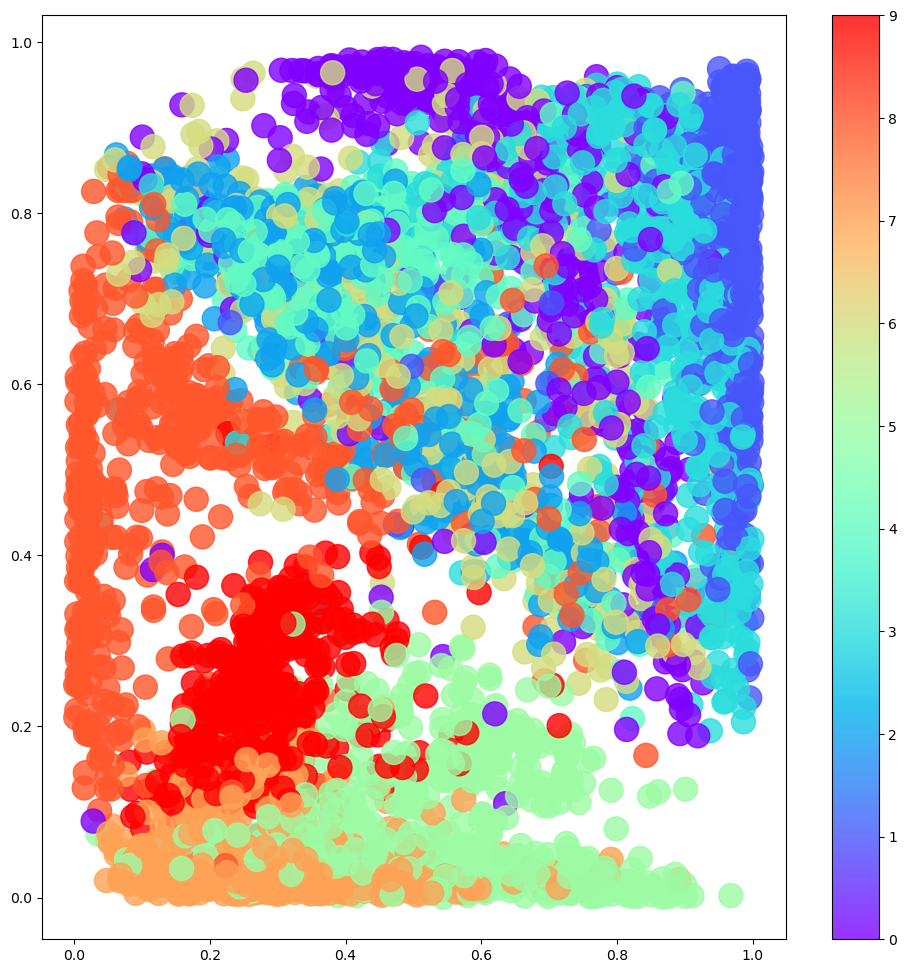

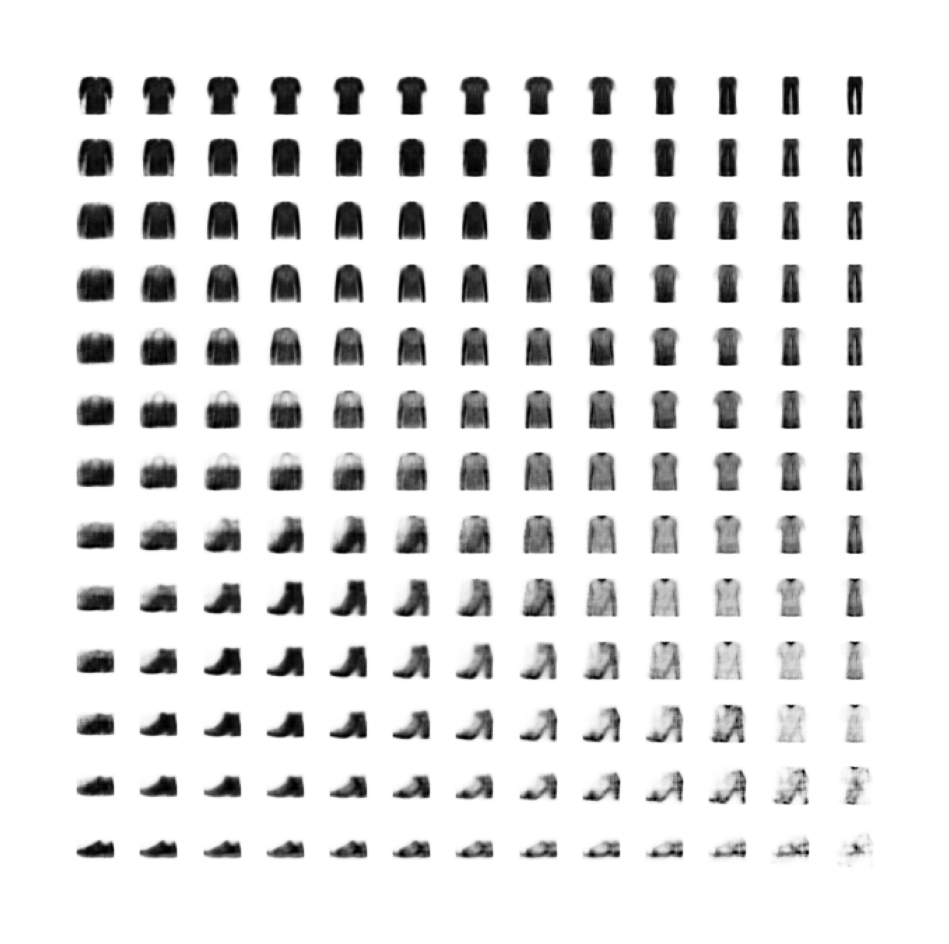

In [30]:
# Colour the embeddings by their label (clothing type - see table)
figsize = 12
grid_size = 15
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    p[:, 0], p[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=300
)
plt.colorbar()

x = norm.ppf(np.linspace(0, 1, grid_size))
y = norm.ppf(np.linspace(1, 0, grid_size))
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
grid = np.array(list(zip(xv, yv)))

reconstructions = decoder.predict(grid)
# plt.scatter(grid[:, 0], grid[:, 1], c="black", alpha=1, s=10)
plt.show()

fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap="Greys")